<a href="https://colab.research.google.com/github/chasubeen/python_selfstudy/blob/master/deep_pytorch/3.%20%EC%8B%AC%EC%B8%B5%20CNN%20%EC%95%84%ED%82%A4%ED%85%8D%EC%B2%98%20(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **모델 처음부터 구현하기**

## **LeNet**

### **a) Import Libraries**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

torch.manual_seed(55)

### **b) 모델 아키텍처 정의**

In [ ]:
class LeNet(nn.Module):
  ### 아키텍처 정의
  def __init__(self):
      super(LeNet, self).__init__()
      ## 합성곱 1
      # 3 input image channel, 6 output feature maps and 5x5 conv kernel
      self.cn1 = nn.Conv2d(3, 6, 5) # 흑백 이미지(channel = 1) 대신 컬러 이미지(channel = 3)를 받도록 수정됨
      ## 합성곱 2
      # 6 input image channel, 16 output feature maps and 5x5 conv kernel
      self.cn2 = nn.Conv2d(6, 16, 5)
      ## 완전 연결 계층 1
      self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 is the spatial dimension at this layer(앞에서 5x5 conv kernel을 통과했으니!)
      ## 완전 연결 계층 2
      self.fc2 = nn.Linear(120, 84)
      ## 완전 연결 계층 3
      self.fc3 = nn.Linear(84, 10)

  ### 전방 전달을 위한 메서드
  def forward(self, x):
      # Convolution with 5x5 kernel
      x = F.relu(self.cn1(x))
      # Max pooling over a (2, 2) window
      x = F.max_pool2d(x, (2, 2))

      # Convolution with 5x5 kernel
      x = F.relu(self.cn2(x))
      # Max pooling over a (2, 2) window
      x = F.max_pool2d(x, (2, 2))

      # Flatten spatial and depth dimensions into a single vector
      x = x.view(-1, self.flattened_features(x)) # 완전 연결 계층을 통과하기 전에 데이터를 1차원으로 펼쳐주는 작업이 필요

      # Fully connected operations
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x) # 마지막 출력 계층 -> 활성화 함수를 적용하지 않아도 ok

      return x

  ### 이미지 표현 계층에서 특징의 전체 개수를 계산
  # 특징의 공간적 표현을 단일 숫자 벡터로 평면화하여 완전 연결 계층의 입력으로 사용할 수 있도록 해줌
  def flattened_features(self, x):
      # 첫 번째 차원(batch)를 제외하고
      size = x.size()[1:]
      num_feats = 1
      for s in size:
          num_feats *= s
      return num_feats

In [ ]:
### 모델 객체 생성

# 모델을 인스턴스화(객체화)
lenet = LeNet()

# 네트워크 아키텍처 출력
print(lenet)

LeNet(
  (cn1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (cn2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### **c) 훈련 루틴 정의**
- 각 epoch마다 전체 훈련 데이터셋을 iteration
- 네트워크를 통해 순전파를 실행
- 역전파를 이용해 지정된 옵티마이저 기반으로 모델 매개변수를 업데이트
- 훈련 데이터셋의 미니 배치를 1000개 실행할 때마다 손실을 계산해 출력

In [ ]:
def train(net, trainloader, optim, epoch):
  # 손실 초기화
  loss_total = 0.0

  for i, data in enumerate(trainloader, 0):
    # 입력을 가져옴, 데이터는 [입력, 레이블]의 리스트 형태
    # ip: 입력 이미지, ground_truth: ip가 속한 이미지의 출력 클래스를 의미
    ip, ground_truth = data

    # 매개변수의 경사를 0으로 설정
    optim.zero_grad()

    # 순전파(forward pass)
    op = net(ip)
    # 역전파(backward pass)
    loss = nn.CrossEntropyLoss()(op, ground_truth)
    loss.backward()
    # 최적화(optimization step)
    optim.step()

    # 손실 업데이트
    loss_total += loss.item()

    # 손실 통계 출력(1000번의 mini-batch마다 출력)
    if (i+1) % 1000 == 0:
      print('[Epoch number : %d, Mini-batches: %5d] loss: %.3f' % (epoch + 1, i + 1, loss_total / 200))
      loss_total = 0.0

### **d) 테스트 루틴 정의**
- 각 테스트셋 이미지에 대해 모델을 통한 순전파를 실행하고 정확히 예측한 수를 계산
- 테스트셋에서 정확히 예측한 비율을 출력

In [ ]:
def test(net, testloader):
  success = 0
  counter = 0
  with torch.no_grad():
    for data in testloader:
      im, ground_truth = data
      op = net(im)
      _, pred = torch.max(op.data, 1)
      counter += ground_truth.size(0)
      success += (pred == ground_truth).sum().item()

  print('LeNet accuracy on 10000 images from test dataset: %d %%' % (100 * success / counter))

### **e) 데이터셋 준비**
- CIFAR-10 데이터셋 활용
- 10개 클래스에 대해 레이블이 있는 32X32 RGB 이미지 6만 개(클래스 당 6천 개 이미지)로 구성됨
  - 5만 개의 훈련 이미지, 1만 개의 테스트 이미지


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 픽셀 값은 원래 0~1 사이이므로 픽셀 값을 정규화하기 위해 평균, 표준편차를 0.5로 유지
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomCrop(32, 4),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/딥러닝 공부/실전! 파이토치 딥러닝 프로젝트/data/CIFAR-10', train = True, download = True, transform = train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 8, shuffle = True, num_workers = 1)

100%|██████████| 170498071/170498071 [00:10<00:00, 15882819.89it/s]


Extracting /content/drive/MyDrive/딥러닝 공부/실전! 파이토치 딥러닝 프로젝트/data/CIFAR-10/cifar-10-python.tar.gz to /content/drive/MyDrive/딥러닝 공부/실전! 파이토치 딥러닝 프로젝트/data/CIFAR-10


In [ ]:
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

testset = torchvision.datasets.CIFAR10(root = '/content/drive/MyDrive/딥러닝 공부/실전! 파이토치 딥러닝 프로젝트/data/CIFAR-10', train = False, download = True, transform = test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = 10000, shuffle = False, num_workers = 2)

Files already downloaded and verified


In [ ]:
## 클래스 정의
# 순서에 주의할 것!

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

### **f) 데이터 확인**

In [ ]:
### 이미지 출력 함수
def imageshow(image):
  # 이미지 비정규화
  image = image/2 + 0.5
  npimage = image.numpy()
  plt.imshow(np.transpose(npimage, (1, 2, 0)))
  plt.show()

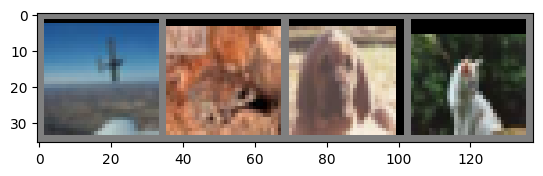

    plane  ||  frog  ||  dog  ||  cat


In [ ]:
# 훈련 데이터셋의 샘플 이미지
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 그리드에 이미지 표시
num_images = 4
imageshow(torchvision.utils.make_grid(images[:num_images]))

# 레이블 출력
print('    '+'  ||  '.join(classes[labels[j]] for j in range(num_images)))

### **g) LeNet 훈련하기**

**옵티마이저 정의, 훈련 루프 시작**

In [ ]:
# 옵티마이저 정의
optim = torch.optim.Adam(lenet.parameters(), lr = 0.001)

# 훈련 loop 정의
for epoch in range(50):
  train(lenet, trainloader, optim, epoch)
  print()
  test(lenet, testloader)
  print()

print('Finished Training')

[Epoch number : 1, Mini-batches:  1000] loss: 9.748
[Epoch number : 1, Mini-batches:  2000] loss: 8.827
[Epoch number : 1, Mini-batches:  3000] loss: 8.377
[Epoch number : 1, Mini-batches:  4000] loss: 8.145
[Epoch number : 1, Mini-batches:  5000] loss: 7.892
[Epoch number : 1, Mini-batches:  6000] loss: 7.650

LeNet accuracy on 10000 images from test dataset: 46 %

[Epoch number : 2, Mini-batches:  1000] loss: 7.351
[Epoch number : 2, Mini-batches:  2000] loss: 7.389
[Epoch number : 2, Mini-batches:  3000] loss: 7.385
[Epoch number : 2, Mini-batches:  4000] loss: 7.165
[Epoch number : 2, Mini-batches:  5000] loss: 6.987
[Epoch number : 2, Mini-batches:  6000] loss: 6.963

LeNet accuracy on 10000 images from test dataset: 50 %

[Epoch number : 3, Mini-batches:  1000] loss: 6.890
[Epoch number : 3, Mini-batches:  2000] loss: 6.753
[Epoch number : 3, Mini-batches:  3000] loss: 6.875
[Epoch number : 3, Mini-batches:  4000] loss: 6.671
[Epoch number : 3, Mini-batches:  5000] loss: 6.717
[E

**훈련된 모델 저장**

In [ ]:
model_path = '/content/drive/MyDrive/딥러닝 공부/실전! 파이토치 딥러닝 프로젝트/model/LeNet/cifar_model.pth'
torch.save(lenet.state_dict(), model_path)

### **h) LeNet 테스트하기**

**저장된 모델 로딩 & 예측 결과 만들기**

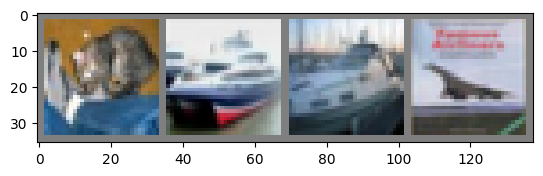

Label:         cat  ship  ship plane
Prediction:    cat plane  ship plane


In [ ]:
# 테스트 데이터셋 이미지 로딩
d_iter = iter(testloader)
im, ground_truth = next(d_iter)

# 이미지 & 실젯값 출력
imageshow(torchvision.utils.make_grid(im[:4]))
print('Label:      ', ' '.join('%5s' % classes[ground_truth[j]] for j in range(4)))

# 모델 로딩
lenet_cached = LeNet()
lenet_cached.load_state_dict(torch.load(model_path))

# 모델 추론
op = lenet_cached(im)

# 예측 결과 출력
_, pred = torch.max(op, 1)

print('Prediction: ', ' '.join('%5s' % classes[pred[j]] for j in range(4)))

- 하나를 제외하고는 예측 결과가 대부분 정확함

**전반적인 정확도 확인**

In [ ]:
success = 0
counter = 0

with torch.no_grad():
  for data in testloader:
    im, ground_truth = data
    op = lenet_cached(im)
    _, pred = torch.max(op.data, 1)
    counter += ground_truth.size(0)
    success += (pred == ground_truth).sum().item()

print('Model accuracy on 10000 images from test dataset: %d %%' % (100 * success / counter))

Model accuracy on 10000 images from test dataset: 66 %


**클래스별 정확도 확인**

In [ ]:
class_sucess = list(0. for i in range(10))
class_counter = list(0. for i in range(10))

with torch.no_grad():
  for data in testloader:
    im, ground_truth = data # 데이터 이미지, 라벨(정답) 준비
    op = lenet_cached(im) # 이미지에 대한 추론
    _, pred = torch.max(op, 1) # 가장 적절한 클래스인 것 같은 것 선택
    c = (pred == ground_truth).squeeze() # 몇 개나 맞았는가

    for i in range(10000):
      ground_truth_curr = ground_truth[i]
      class_sucess[ground_truth_curr] += c[i].item()
      class_counter[ground_truth_curr] += 1

for i in range(10):
  print('Model accuracy for class %5s : %2d %%' % (classes[i], 100 * class_sucess[i] / class_counter[i]))

Model accuracy for class plane : 64 %
Model accuracy for class   car : 86 %
Model accuracy for class  bird : 65 %
Model accuracy for class   cat : 42 %
Model accuracy for class  deer : 60 %
Model accuracy for class   dog : 44 %
Model accuracy for class  frog : 76 %
Model accuracy for class horse : 76 %
Model accuracy for class  ship : 76 %
Model accuracy for class truck : 76 %


고양이와 강아지를 구분하지 못하는 멍청한 기계같으니라구..

# **사전 훈련 모델 활용하기**

## **1. AlexNet**

### **a) Import Libraries**

In [ ]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

torch.manual_seed(0)

### **b) 데이터셋 준비**
- 모델 미세 조정을 위해 벌과 개미 이미지로 구성된 작은 데이터셋을 사용
- 240개의 훈련 이미지와 150개의 검증 이미지가 두 개의 클래스에 균등하게 나누어져 있음

In [ ]:
## 데이터 경로 지정
ddir = '/content/drive/MyDrive/딥러닝 공부/실전! 파이토치 딥러닝 프로젝트/data/hymenoptera_data/'

## 훈련 데이터셋을 위한 데이터 정규화 및 데이터 보강
# 검증 데이터셋에는 데이터 정규화만 적용
# 정규화를 위해 평균/표준편차는 이미지 채널(R, G, B)당 훈련 셋의 모든 이미지의 모든 픽셀값의 평균으로 계산
data_transformers = {
    'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.490, 0.449, 0.411], [0.231, 0.221, 0.230])]),
    'val': transforms.Compose([transforms.Resize(256),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize([0.490, 0.449, 0.411], [0.231, 0.221, 0.230])])}

In [ ]:
img_data = {k: datasets.ImageFolder(os.path.join(ddir, k), data_transformers[k]) for k in ['train', 'val']} # 이미지
dloaders = {k: torch.utils.data.DataLoader(img_data[k], batch_size=8, shuffle=True, num_workers=2) for k in ['train', 'val']} # 데이터로더 정의
dset_sizes = {x: len(img_data[x]) for x in ['train', 'val']} # 데이터 크기
classes = img_data['train'].classes # 클래스 정의
dvc = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # 장치 정의

### **c) 데이터 확인**
- 일부 훈련 데이터셋 시각화

In [ ]:
### 이미지 확인을 위한 함수

def imageshow(img, text = None):
  img = img.numpy().transpose((1, 2, 0))
  avg = np.array([0.490, 0.449, 0.411])
  stddev = np.array([0.231, 0.221, 0.230])
  img = stddev * img + avg
  img = np.clip(img, 0, 1)
  plt.imshow(img)

  if text is not None:
    plt.title(text)

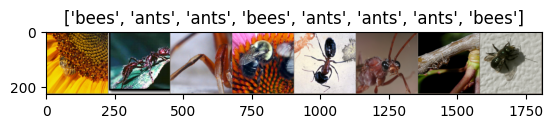

In [ ]:
# 훈련 데이터셋 배치 생성
imgs, cls = next(iter(dloaders['train']))

# 배치에서 그리드 생성
grid = torchvision.utils.make_grid(imgs)

imageshow(grid, text = [classes[c] for c in cls])

### **d) fine-tuning**
- 사전 훈련된 모델을 훈련시키는 미세 조정 루틴 정의
- 가중치를 임의로 인스턴스화하는 대신 AlexNet의 사전 훈련된 가중치로 시작

In [ ]:
def finetune_model(pretrained_model, loss_func, optim, epochs = 10):
    start = time.time()

    model_weights = copy.deepcopy(pretrained_model.state_dict()) # 가중치
    accuracy = 0.0 # 정확도

    ## 1 epoch마다..
    for e in range(epochs):
        print(f'Epoch number {e}/{epochs - 1}')
        print('=' * 20)

        # 각 epoch마다 train & validation
        for dset in ['train', 'val']:
            if dset == 'train':
                pretrained_model.train()  # 훈련 모드
            else:
                pretrained_model.eval()   # 검증 모드

            loss = 0.0 # 손실
            successes = 0 # 정확한 예측의 수

            # 반복(iteration)
            for imgs, tgts in dloaders[dset]: # 이미지(feature), 정답(target)
                imgs = imgs.to(dvc)
                tgts = tgts.to(dvc)
                optim.zero_grad()

                with torch.set_grad_enabled(dset == 'train'):
                    ops = pretrained_model(imgs)
                    _, preds = torch.max(ops, 1)
                    loss_curr = loss_func(ops, tgts)

                    # backward pass only if in training mode
                    if dset == 'train':
                        loss_curr.backward()
                        optim.step()

                loss += loss_curr.item() * imgs.size(0)
                successes += torch.sum(preds == tgts.data)

            loss_epoch = loss / dset_sizes[dset]
            accuracy_epoch = successes.double() / dset_sizes[dset]
            print(f'{dset} loss in this epoch: {loss_epoch}, accuracy in this epoch: {accuracy_epoch}')

            if dset == 'val' and accuracy_epoch > accuracy:
                accuracy = accuracy_epoch
                model_weights = copy.deepcopy(pretrained_model.state_dict())
        print()

    time_delta = time.time() - start
    print(f'Training finished in {time_delta // 60}mins {time_delta % 60}secs')
    print(f'Best validation set accuracy: {accuracy}')

    # load the best model version (weights)
    pretrained_model.load_state_dict(model_weights)

    return pretrained_model

### **e) 예측 시각화 함수 정의**

In [ ]:
def visualize_predictions(pretrained_model, max_num_imgs = 4):
  torch.manual_seed(1)

  was_model_training = pretrained_model.training
  pretrained_model.eval()
  imgs_counter = 0
  fig = plt.figure()

  with torch.no_grad():
      for i, (imgs, tgts) in enumerate(dloaders['val']):
          imgs = imgs.to(dvc)
          tgts = tgts.to(dvc)
          ops = pretrained_model(imgs)
          _, preds = torch.max(ops, 1)

          for j in range(imgs.size()[0]):
              imgs_counter += 1
              ax = plt.subplot(max_num_imgs//2, 2, imgs_counter)
              ax.axis('off')
              ax.set_title(f'pred: {classes[preds[j]]} || target: {classes[tgts[j]]}')
              imageshow(imgs[j].cpu().data)

              if imgs_counter == max_num_imgs:
                  pretrained_model.train(mode=was_model_training)
                  return
      pretrained_model.train(mode=was_model_training)

### **f) 훈련**

**사전 학습된 AlexNet 모델 로딩**  
- 모델은 다음의 두 영역으로 구성됨
  - features: 특징을 추출하는 영역, 합성곱 계층과 풀링 계층을 전부 포함
  - classifier: 분류기 영역, 출력 계층 앞에 위치한 완전 연결 계층을 모두 포함

In [ ]:
model_finetune = models.alexnet(pretrained = True).to(dvc)

In [ ]:
print(model_finetune.features)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [ ]:
print(model_finetune.classifier)

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


**마지막 출력층 조정**  
- 2개의 클래스를 구분하도록

In [ ]:
# 마지막 계층을 1000개 클래스에서 2개 클래스로 변경

model_finetune.classifier[6] = nn.Linear(4096, len(classes)).to(dvc) # 마지막 FC Layer

**옵티마이저, 손실 함수 정의**

In [ ]:
loss_func = nn.CrossEntropyLoss()
optim_finetune = optim.SGD(model_finetune.parameters(), lr=0.0001)

**Run!!**

In [ ]:
## 모델 훈련(미세 조정) 및 검증

model_finetune = finetune_model(model_finetune, loss_func, optim_finetune, epochs=10)

Epoch number 0/9
train loss in this epoch: 0.6055278133173458, accuracy in this epoch: 0.6516393442622951
val loss in this epoch: 0.5443088081147935, accuracy in this epoch: 0.7124183006535948

Epoch number 1/9
train loss in this epoch: 0.5338679043973078, accuracy in this epoch: 0.7254098360655739
val loss in this epoch: 0.46881338026301533, accuracy in this epoch: 0.7843137254901961

Epoch number 2/9
train loss in this epoch: 0.4385046636471983, accuracy in this epoch: 0.8155737704918034
val loss in this epoch: 0.4192707819097182, accuracy in this epoch: 0.8366013071895425

Epoch number 3/9
train loss in this epoch: 0.4195711085053741, accuracy in this epoch: 0.819672131147541
val loss in this epoch: 0.38386033173480066, accuracy in this epoch: 0.8496732026143791

Epoch number 4/9
train loss in this epoch: 0.37809126201223153, accuracy in this epoch: 0.8319672131147542
val loss in this epoch: 0.36049868448886996, accuracy in this epoch: 0.8496732026143791

Epoch number 5/9
train loss

### **g) 추론**

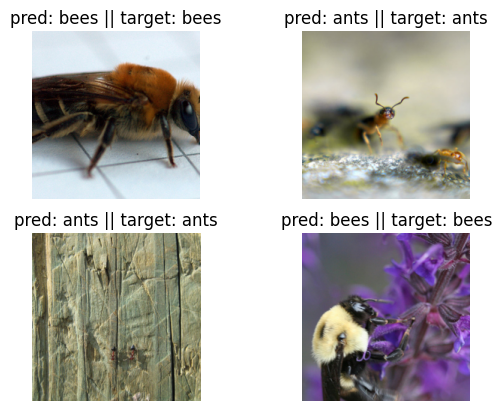

In [ ]:
visualize_predictions(model_finetune)

학습과 추론이 정확하게 이뤄진 것 같다고 판단된다.

## **2. VGGNet**

### **a) Import Libraries**

In [1]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

torch.manual_seed(0)

### **b) 데이터셋 준비**
- 모델 미세 조정을 위해 벌과 개미 이미지로 구성된 작은 데이터셋을 사용
- 240개의 훈련 이미지와 150개의 검증 이미지가 두 개의 클래스에 균등하게 나누어져 있음

In [2]:
## 데이터 경로 지정
ddir = '/content/drive/MyDrive/딥러닝 공부/실전! 파이토치 딥러닝 프로젝트/data/hymenoptera_data/'

## 훈련 데이터셋을 위한 데이터 정규화 및 데이터 보강
# 검증 데이터셋에는 데이터 정규화만 적용
# 정규화를 위해 평균/표준편차는 이미지 채널(R, G, B)당 훈련 셋의 모든 이미지의 모든 픽셀값의 평균으로 계산
data_transformers = {
    'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.490, 0.449, 0.411], [0.231, 0.221, 0.230])]),
    'val': transforms.Compose([transforms.Resize(256),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize([0.490, 0.449, 0.411], [0.231, 0.221, 0.230])])}

In [4]:
img_data = {k: datasets.ImageFolder(os.path.join(ddir, k), data_transformers[k]) for k in ['train', 'val']} # 이미지
dloaders = {k: torch.utils.data.DataLoader(img_data[k], batch_size=8, shuffle=True, num_workers=2) for k in ['train', 'val']} # 데이터로더 정의
dset_sizes = {x: len(img_data[x]) for x in ['train', 'val']} # 데이터 크기
classes = img_data['train'].classes # 클래스 정의
dvc = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # 장치 정의

### **c) 데이터 확인**
- ImageNet 데이터셋의 1000개 레이블 확인
- 0 ~ 999까지 클래스 인덱스와 그에 대응하는 클래스 레이블 간의 매핑 생성

In [6]:
import ast

with open('/content/drive/MyDrive/딥러닝 공부/실전! 파이토치 딥러닝 프로젝트/data/imagenet1000_clsidx_to_labels.txt') as f:
  classes_data = f.read()
classes_dict = ast.literal_eval(classes_data)
print({k: classes_dict[k] for k in list(classes_dict)[:5]})

{0: 'tench, Tinca tinca', 1: 'goldfish, Carassius auratus', 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 3: 'tiger shark, Galeocerdo cuvieri', 4: 'hammerhead, hammerhead shark'}


### **d) 모델 불러오기**

In [8]:
model_finetune = models.vgg13(pretrained = True).to(dvc)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG13_Weights.IMAGENET1K_V1`. You can also use `weights=VGG13_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg13-19584684.pth" to /root/.cache/torch/hub/checkpoints/vgg13-19584684.pth
100%|██████████| 508M/508M [00:03<00:00, 148MB/s]


### **e) 예측 시각화 함수 정의**

In [11]:
def imageshow(img, text=None):
    img = img.numpy().transpose((1, 2, 0))
    avg = np.array([0.490, 0.449, 0.411])
    stddev = np.array([0.231, 0.221, 0.230])
    img = stddev * img + avg
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if text is not None:
        plt.title(text)

def visualize_predictions(pretrained_model, max_num_imgs=4):
    torch.manual_seed(1)
    was_model_training = pretrained_model.training
    pretrained_model.eval()
    imgs_counter = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (imgs, tgts) in enumerate(dloaders['val']):
            imgs = imgs.to(dvc)
            ops = pretrained_model(imgs)
            _, preds = torch.max(ops, 1)

            for j in range(imgs.size()[0]):
                imgs_counter += 1
                ax = plt.subplot(max_num_imgs//2, 2, imgs_counter)
                ax.axis('off')
                ax.set_title(f'pred: {classes_dict[int(preds[j])]}')
                imageshow(imgs.cpu().data[j])

                if imgs_counter == max_num_imgs:
                    pretrained_model.train(mode=was_model_training)
                    return
        pretrained_model.train(mode=was_model_training)

### **f) 추론**

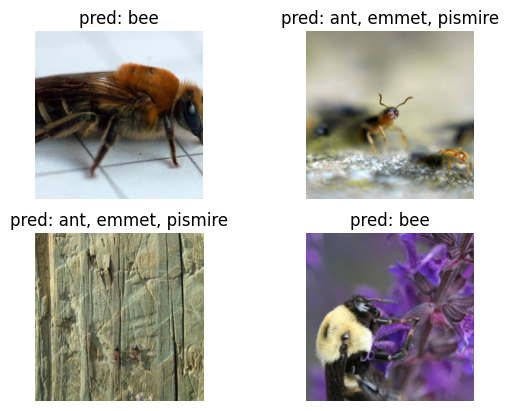

In [12]:
visualize_predictions(model_finetune)

- 완전히 다른 데이터셋에서 훈련된 VGG13 모델이 개미와 벌 데이터셋에서 추출한 테스트 샘플을 모두 정확하게 예측하는 것을 확인할 수 있다.
- 해당 모델은 데이터셋에서 1000개 클래스 중 가장 비슷한 두 개의 동물을 잡아 이미지에서 이 둘을 찾아냄
